<a href="https://colab.research.google.com/github/Yvnminc/COMP5329_A1/blob/main/COlip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clip (ViT and Transformer all included)

In [1]:
pip install -q openai-clip 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00


In [2]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#get the data from the drive
id = '1iIl3Yj4I2aowyVNj1NDWVclh3CSCgu76'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('multi-label-classification-competition-2023.zip')
#unzip the dataset
!unzip multi-label-classification-competition-2023.zip > /dev/null

In [3]:
import re
import pandas as pd
from io import StringIO

FILENAME = '/content/COMP5329S1A2Dataset/train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    error_num = [4790,14716,14961,29895]
    for i in error_num:
      lines[i] = lines[i][:-3]+lines[i][-2:]
    df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
df

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...
29997,29997.jpg,1,A man riding a snowboard on top of snow.
29998,29998.jpg,1,This photo shows people skiing in the mountains.


In [4]:
label_set = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

In [5]:
df["Labels"].iloc[1]

single_label_list = [int(x) for x in df["Labels"].iloc[4].split()]
binary_vector = [1 if label in single_label_list else 0 for label in label_set]
binary_vector

[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Dataloader and augmentation

In [6]:
from torch.utils.data import Dataset, DataLoader
import re
import pandas as pd
import random
from io import StringIO
import torchvision.transforms as T
from torch.utils.data import random_split
import torch
import matplotlib.pyplot as plt
import os
import clip
from PIL import Image
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

FILENAME_TRAIN = '/content/COMP5329S1A2Dataset/train.csv'
FILENAME_TEST = '/content/COMP5329S1A2Dataset/test.csv'
DATA_PATH =  '/content/COMP5329S1A2Dataset/data'

class MmDataset(Dataset):
    def __init__(self,
                data_aug = True,
                indices= None,
                img_size = 224,
                iters = 1000,
                mode = "training"):
        
        df= read_path(mode)

        self.mode = mode
        self.image_filenames = df["ImageID"]
        self.captions = df["Caption"]

        if self.mode == "training":
            self.labels = df["Labels"]
        else:
          self.labels = df["Caption"].apply(lambda x: np.nan)

        self.data_aug = data_aug   
        self.indices = indices
        self.img_size = img_size
        self.iters = iters
        self.total_iters = iters
        self.all_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

        # To initialise the dataset
        if indices is not None:
            self.image_filenames = [self.image_filenames[i] for i in indices]
            self.captions = [self.captions[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
        
        # #self.mean, self.std = self.compute_mean_std()
        
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            # T.RandomRotation(degrees= (0, 45)),
            #T.RandomAutocontrast(),
            #T.RandomAdjustSharpness(sharpness_factor=3),
            #T.Pad(padding= random.randint(a = 0, b = int(self.img_size / 2))),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            #T.ElasticTransform(alpha=50.0),
            #T.RandomPosterize(bits=2),
            #T.RandomEqualize(),
            #T.TrivialAugmentWide(),
            T.ColorJitter(brightness=0.5,  # 亮度调整因子的范围，可以是浮点数或(min, max)元组
                          contrast=0.5,    # 对比度调整因子的范围，可以是浮点数或(min, max)元组
                          saturation=0.5,  # 饱和度调整因子的范围，可以是浮点数或(min, max)元组
                          hue=0.5           # 色相调整因子的范围，必须是浮点数，介于-0.5到0.5之间
                      )
        ])

        self.resize = T.Compose([
            T.Resize((self.img_size, self.img_size)),
            T.ToTensor(),
        ])

    def __getitem__(self, index):

        # Load images and labels
        image_path = os.path.join(DATA_PATH, self.image_filenames[index])
        prob = random.random()
        image = Image.open(image_path)

        if self.mode == "training":
          label_list = [int(x) for x in self.labels[index].split()]
          label = torch.from_numpy(np.array([1 if label in label_list else 0 for label in self.all_labels]).astype(np.float32)).unsqueeze(dim=0)
        else:
          label = self.labels[index]

        caption = self.captions[index]
             
        # arg_threshold = self.iters/self.total_iters
        # self.iters = self.iters -1

        # if self.data_aug and prob < arg_threshold:
        #     view2 = self.transforms(view2)

        view1 = self.resize(image)
        view2 = self.resize(image)

        return view1, view2, caption, label

    def __len__(self):
        return len(self.image_filenames)

def read_path(mode = "training"):
  
  if mode == "training":
    with open(FILENAME_TRAIN) as file:
      lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
      error_num = [4790,14716,14961,29895]
      for i in error_num:
        lines[i] = lines[i][:-3]+lines[i][-2:]
    
    return pd.read_csv(StringIO(''.join(lines)), escapechar="/")

  with open(FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
  
  return pd.read_csv(StringIO(''.join(lines)), escapechar="/")


def get_loader(data_aug = None, bs = 8, img_size = 224, load_clip = False):
  # # Set the seed empirically
  # torch.manual_seed(3407)
  
  # 创建完整trainig和validation的数据集
  full_dataset = MmDataset(img_size= img_size)
  dataset_length = len(full_dataset)

  test_dataset = MmDataset(img_size= img_size, mode = "testing")

  # 计算训练、验证和测试集的长度
  train_length = int(0.9 * dataset_length)
  val_length = int(0.1 * dataset_length)

  # 使用 random_split 函数拆分数据集
  train_dataset, val_dataset = random_split(full_dataset, [train_length, val_length])

  # 使用相应的索引创建 MmDataset 实例
  train_dataset = MmDataset(img_size= img_size, data_aug= True, 
                            indices=train_dataset.indices)
  
  val_dataset = MmDataset(img_size= img_size, data_aug= False, 
                          indices=val_dataset.indices)

  # 现在您可以使用这些拆分数据集创建 DataLoader
  train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

  return train_loader, val_loader, test_loader


def imshow(img, title=None, cmap=None):
    # Convert from Tensor to NumPy array and transpose to (H, W, C)
    img = img.numpy().transpose((1, 2, 0))

    # Undo normalization if necessary
    if img.min() < 0 or img.max() > 1:
        img = img * 0.5 + 0.5

    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

def plot_loder(dataloader):
    # Get a batch of data
    view1, view2, caption, label = next(iter(dataloader))
    # Display the first image and its corresponding label
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(view1[0], title='Original image')
    plt.subplot(1, 2, 2)
    imshow(view2[0], title='Augmented image')
    print(f"The caption is: {caption[0]}, the label is: {label[0]}")
    plt.show()


def print_shape(dataloader):
  view1, view2, caption, label = next(iter(dataloader))
  print(f"View1 is with shape: {view1.shape}, the type is {view1.dtype}.")
  print(f"View2 is with shape: {view2.shape}, the type is {view2.dtype}.")
  print(f"Label is with shape: {label.shape}, the type is {label.dtype}.")

In [7]:
train_loader, val_loader, test_loader = get_loader(bs = 1)

In [8]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

27000
3000
10000


The caption is: Two zebra standing next to each other on a lush green field., the label is: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


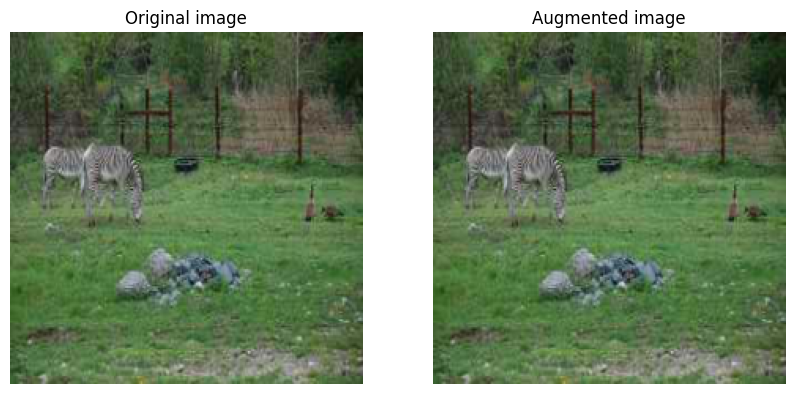

In [9]:
plot_loder(train_loader)

The caption is: A little girl waring a krispy kreme hat holding a box of krispy kreme donuts., the label is: nan


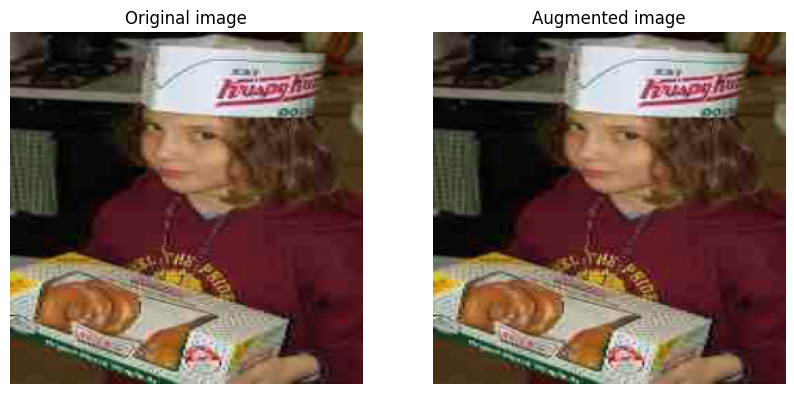

In [10]:
plot_loder(test_loader)

In [11]:
print_shape(train_loader)
print_shape(val_loader)
print_shape(test_loader)

View1 is with shape: torch.Size([1, 3, 224, 224]), the type is torch.float32.
View2 is with shape: torch.Size([1, 3, 224, 224]), the type is torch.float32.
Label is with shape: torch.Size([1, 1, 18]), the type is torch.float32.
View1 is with shape: torch.Size([1, 3, 224, 224]), the type is torch.float32.
View2 is with shape: torch.Size([1, 3, 224, 224]), the type is torch.float32.
Label is with shape: torch.Size([1, 1, 18]), the type is torch.float32.
View1 is with shape: torch.Size([1, 3, 224, 224]), the type is torch.float32.
View2 is with shape: torch.Size([1, 3, 224, 224]), the type is torch.float32.
Label is with shape: torch.Size([1]), the type is torch.float64.


# CLIP features

In [12]:
model, preprocess = clip.load('ViT-B/32', "cuda")

100%|███████████████████████████████████████| 338M/338M [00:25<00:00, 14.1MiB/s]


In [13]:
view1, view2, caption, label = next(iter(train_loader))
print(view1.shape)
view1 = view1.to("cuda")
view1_feature = model.encode_image(view1) 

torch.Size([1, 3, 224, 224])


In [14]:
print(view1_feature.shape)

torch.Size([1, 512])


In [15]:
print(view1_feature.dtype)

torch.float16


## Feature fusions

In [23]:
import torch.nn as nn

class FEATURE_DECISION_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 18)
        self.fc4 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, inputs):
        inputs = inputs.view(inputs.size(0), -1)  # 添加此行以调整输入张量的形状
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = self.dropout(tensor)
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

class DECISION_DECISION_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

In [17]:
pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.9 MB/s eta 0:00:00


In [21]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import F1Score
from torch import optim

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
def Trainer(net, epoch):
  
    train_loader, val_loader, _ = get_loader(bs = 512)

    dev = "cuda" if torch.cuda.is_available() else "cpu"
    Net = net.to(dev)
    opti = optim.Adam(Net.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epoch
    loss_list = []
    f1_list = []

    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        view1, view2, cap, label = next(iter(train_loader))

        label = label.squeeze(1)  # 添加此行以调整目标张量的形状
        preds = Net(model.encode_image(view1.to("cuda")).float())        
        loss = F.binary_cross_entropy(preds, label.to(dev))
        loss.backward()
        opti.step()
        scheduler.step()
        opti.zero_grad()
        loss_list.append(loss)

        Net.eval()
        with torch.autograd.no_grad():
            view1_val, view2_val, cap, label_val = next(iter(val_loader))

            label_val = label.squeeze(1)  # 添加此行以调整目标张量的形状

            predict = Net(model.encode_image(view1_val.to("cuda")).float())

            f1_score = f1(predict, label_val.to("cuda"))
            print('F1 in epoch{} : {:.4f}'.format(epoch, f1_score))
        f1_list.append(f1_score)
    
    return Net, loss_list, f1_list

def clip_feature(view1, view2, caption, model, preprocess):
      # view1_input = preprocess(view1).unsqueeze(0)
      # view2_input = preprocess(view2).unsqueeze(0)
      # text_inputs = torch.cat([clip.tokenize(f"{caption}")])
      with torch.no_grad():
        view1_features = model.encode_image(view1.to(dev))
        view2_features = model.encode_image(view2.to(dev))
        # text_features = model.encode_text(text_inputs)

      return view1_features.float(), view2_features.float(), text_features.float()

In [ ]:
dev = "cuda" if torch.cuda.is_available() else "cpu"

Net, loss_list, f1_list = Trainer(FEATURE_DECISION_DNN(), 40):
Net.eval()
# with torch.autograd.no_grad():
#     img_train = Net(all_image_features.to(dev))
#     img_test = Net(test_image_features.to(dev))

  0%|          | 1/480 [00:04<35:57,  4.50s/it]

F1 in epoch0 : 0.2718


  0%|          | 2/480 [00:08<35:07,  4.41s/it]

F1 in epoch1 : 0.5113


  1%|          | 3/480 [00:13<34:49,  4.38s/it]

F1 in epoch2 : 0.6285


  1%|          | 4/480 [00:17<34:51,  4.39s/it]

F1 in epoch3 : 0.5998


  1%|          | 5/480 [00:21<34:35,  4.37s/it]

F1 in epoch4 : 0.5655


  1%|▏         | 6/480 [00:26<35:03,  4.44s/it]

F1 in epoch5 : 0.5775


  1%|▏         | 7/480 [00:30<35:03,  4.45s/it]

F1 in epoch6 : 0.5943


  2%|▏         | 8/480 [00:35<35:01,  4.45s/it]

F1 in epoch7 : 0.6090


  2%|▏         | 9/480 [00:40<35:30,  4.52s/it]

F1 in epoch8 : 0.6201


  2%|▏         | 10/480 [00:44<35:14,  4.50s/it]

F1 in epoch9 : 0.6077


  2%|▏         | 11/480 [00:48<34:57,  4.47s/it]

F1 in epoch10 : 0.5651


  2%|▎         | 12/480 [00:53<35:48,  4.59s/it]

F1 in epoch11 : 0.5986


  3%|▎         | 13/480 [00:58<35:04,  4.51s/it]

F1 in epoch12 : 0.5791


In [ ]:
Net, loss_list, f1_list = Trainer(FEATURE_DECISION_DNN(), 360, 360, 360, all_text_feature)
Net.eval()
with torch.autograd.no_grad():
    txt_train = Net(all_text_feature.to(dev))
    txt_test = Net(test_text_feature.to(dev))

In [ ]:
sum_train = img_train+txt_train
sum_test = img_test+txt_test
Net, loss_list, f1_list = Trainer(DECISION_DECISION_DNN(),300, 220, 270, sum_train)
Net.eval()
with torch.autograd.no_grad():
    final = Net(sum_test)

In [ ]:
y_proba = final.cpu().numpy()

resl = []
for i in y_proba:
  a = [x+1 for x in range(len(i)) if i[x] > 0.5]
  for j in range(len(a)):
    if a[j] >=12:
      a[j] = a[j]+1
  resl.append(a)

test_pred = []
for lis in resl:
  a = [str(i) for i in lis]
  test_pred.append(" ".join(a))

# output_df = pd.DataFrame(test_pred, columns = ['Labels'])

# # The best model of our prediction data on kaggle is svm.
# # Select the prediction of svm model for output.
# output_df = pd.DataFrame(test_pred, columns = ['Labels'])
# output_df.to_csv('/content/Predicted_labels.csv')
# df.to_csv("/content/Predicted_labels.csv".format(str(output_df)), index= False)
# print

# make a csv file
df = pd.DataFrame(columns=["ImageID", "Labels"])
# Creating the Second Dataframe using dictionary
for index, value in enumerate(test_pred):
    df_temp = pd.DataFrame({"ImageID":"{}.jpg".format(30000+index), "Labels":" ".join([str(i) for i in [value]])}, index=[0])
    # for appending df_temp at the end of df
    df = df.append(df_temp, ignore_index = True)

df.to_csv("/content/Predicted_labels.csv", index = False)